In [37]:
#Importing libraries for ML model.
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as St
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve,ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import pandas as pd
import numpy as np




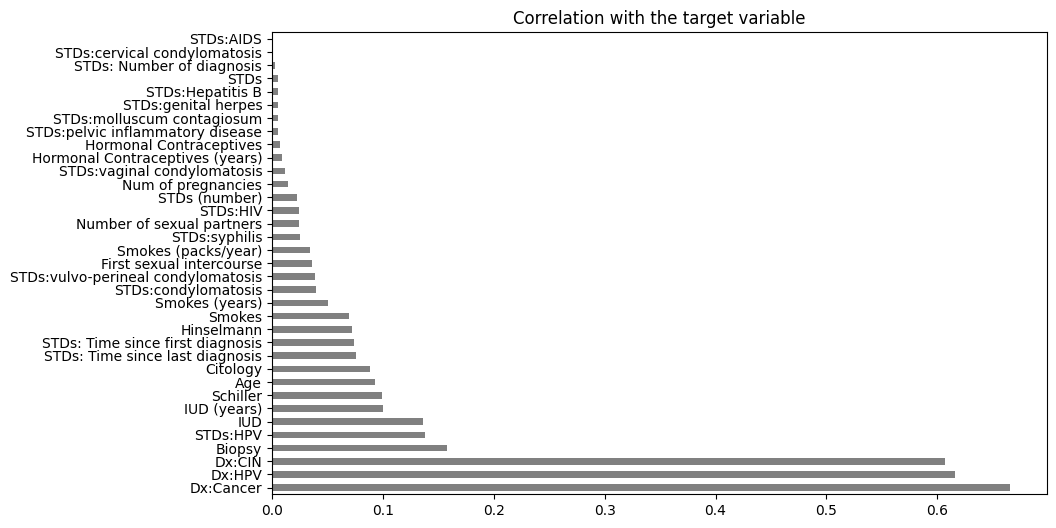

In [8]:
data=pd.read_csv('CleanData.csv')
# Correlation graph of the variables respect to Dx
corr = data.corr()
var = corr['Dx'].drop('Dx').abs().sort_values(ascending=False)
plt.figure(figsize=(10,6))
var.plot(kind='barh',color='grey')
plt.title('Correlation with the target variable')
plt.show()

In [9]:
#Divide the data for X an y and split the data for training and testing
X= data.drop(columns=['Dx'])#All the variables except the target one
y=data['Dx']#Just the target value
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
# We divide the data in training and testing data, the testing data is 20% of the total data with a random seed of 42 and focusing on y variable.

In [10]:
scaler=St()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
# We scale the data to have a mean of 0 and a standard deviation of 1.

In [15]:
smote=SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# We resample the data using SMOTE to balance the data.
print(f'\n Balanced data for y: {y_train_resampled.shape} vs Original Data for y: {y_train.shape}')
print(f'\n Balanced data for X: {X_train_resampled.shape} vs Original Data for X: {X_train.shape}')




 Balanced data for y: (1334,) vs Original Data for y: (686,)



 Balanced data for X: (1334, 35) vs Original Data for X: (686, 35)



 Number of components to explain 95% of the variance: 18


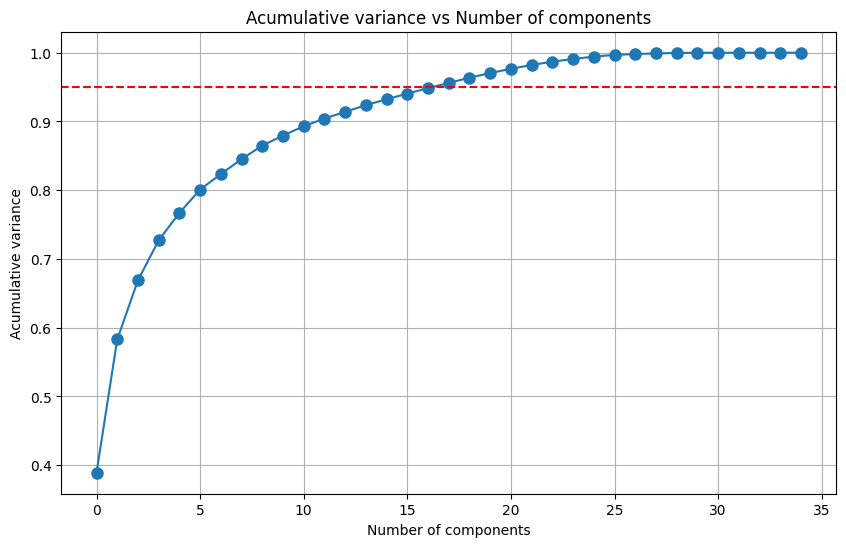

In [20]:
#We apply PCA to the data to reduce the number of variables.
pca=PCA()
X_train_pca=pca.fit_transform(X_train_resampled)
X_test_pca=pca.transform(X_test)    

#Find optim number of variables for the model.
vc=np.cumsum(pca.explained_variance_ratio_)
num_components=np.argmax(vc>0.95)+1
print(f'\n Number of components to explain 95% of the variance: {num_components}')

#Acumulative variance graph
plt.figure(figsize=(10,6))
plt.plot(vc,marker='o',linestyle='-',markersize=8)
plt.axhline(y=0.95,color='r',linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Acumulative variance')
plt.title('Acumulative variance vs Number of components')
plt.grid(True)
plt.show()


In [39]:
#From original 36 variables, just 18 can explain 95% of the variance of the data.
pca=PCA(n_components=num_components)
X_train_pca=pca.fit_transform(X_train_resampled)
X_test_pca=pca.transform(X_test)
print(pca.components_.shape)


(18, 35)


In [40]:
#Make them tensors from pytorch
X_train_tensor=torch.tensor(X_train_pca,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_resampled,dtype=torch.float32)
X_test_tensor=torch.tensor(X_test_pca,dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32)
tensors = {
    "X_train_tensor": X_train_tensor,
    "X_test_tensor": X_test_tensor,
    "y_train_tensor": y_train_tensor,
    "y_test_tensor": y_test_tensor
}
print("\n".join([f"\nTamaño de tensor {name}: {tensor.shape}" for name, tensor in tensors.items()]))


Tamaño de tensor X_train_tensor: torch.Size([1334, 18])

Tamaño de tensor X_test_tensor: torch.Size([172, 18])

Tamaño de tensor y_train_tensor: torch.Size([1334])

Tamaño de tensor y_test_tensor: torch.Size([172])


In [42]:
#Dataset in Pytorch
train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
test_dataset=TensorDataset(X_test_tensor,y_test_tensor)

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)


In [43]:
#Create a Neuronal network
class DMLP(nn.Module):
    def __init__(self,input_size,hidden_sizes,output_size,dropout_rate):
        super(DMLP,self).__init__()
        layers=[]
        in_size=input_size

        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_size,h_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_size=h_size
        
        layers.append(nn.Linear(in_size,output_size))
        layers.append(nn.Softmax(dim=1))
        self.network=nn.Sequential(*layers)
    def forward(self,x):
        return self.network(x)



**R**

In [44]:
#Create an Early Stopping Function to make the trainment better and avoid the overfitting
def early_stopping(model,train_loader,criterion,optimizer,num_epochs=20,patience=3):
    model.train()
    best_loss=float('inf')
    epochs_without_improvement=0
    for epoch in range(num_epochs):
        running_loss=0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,labels.long())
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        avg_loss=running_loss/len(train_loader)
        print(f'\nEpoch{epoch+1}/{num_epochs},Loss:{avg_loss}')
        if avg_loss<best_loss:
            best_loss,epochs_without_improvement=avg_loss,0
        else:
            epochs_without_improvement +=1
        if epochs_without_improvement>= patience:
            print("Early Stopping Triggered, the model has not improved")
            break
        
            

    


In [45]:
#Initialize Parameters.
input_size=X_test_tensor.shape[1]
hidden_layers=[256,128,64,32,16]
output_size=2
dropout_rate=0.5
model=DMLP(input_size,hidden_layers,output_size,dropout_rate)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

#Train with Early Stopping
early_stopping(model,train_loader,criterion,optimizer,num_epochs=20,patience=3)

#Evaluate the model
def evaluate(model,test_loader,):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for inputs,labels in test_loader:
            outputs=model(inputs)
            _, predicted=torch.max(outputs,1)
            total+= labels.size(0)
            correct+=(predicted==labels).sum().item()
    accuracy=100*correct/total
    return accuracy
accuracy=evaluate(model,test_loader)
print(f'Accuracy with the Deep Neuronal Network:{accuracy:.2f}%')




Epoch1/20,Loss:0.6391012420256933

Epoch2/20,Loss:0.43777565587134587

Epoch3/20,Loss:0.3536609886657624

Epoch4/20,Loss:0.342394918912933

Epoch5/20,Loss:0.32966063774767373

Epoch6/20,Loss:0.32814588362262365

Epoch7/20,Loss:0.32665114956242697

Epoch8/20,Loss:0.32238730291525525

Epoch9/20,Loss:0.3215715721959159

Epoch10/20,Loss:0.32120001032238915

Epoch11/20,Loss:0.32106599566482363

Epoch12/20,Loss:0.3198924284605753

Epoch13/20,Loss:0.3182247813258852

Epoch14/20,Loss:0.3192475913535981

Epoch15/20,Loss:0.3185384976012366

Epoch16/20,Loss:0.3172031037864231

Epoch17/20,Loss:0.32010409023080555

Epoch18/20,Loss:0.31828572494643076

Epoch19/20,Loss:0.31781397192251115
Early Stopping Triggered, the model has not improved
Accuracy with the Deep Neuronal Network:99.42%


In [47]:
kfold=KFold(n_splits=5, shuffle=True,random_state=42)
fold_accuracies=[]
for fold,(train_index,val_index) in enumerate(kfold.split(X_train_pca)):
    print(f'Fold{fold+1}')
    X_train_fold,X_val_fold=X_train_pca[train_index],X_train_pca[val_index]
    y_train_fold,y_val_fold=y_train_resampled.iloc[train_index],y_train_resampled.iloc[val_index]

    train_tensor=TensorDataset(torch.tensor(X_train_fold,dtype=torch.float32),torch.tensor(y_train_fold.values,dtype=torch.float32))
    val_tensor=TensorDataset(torch.tensor(X_val_fold,dtype=torch.float32),torch.tensor(y_val_fold.values,dtype=torch.float32))

    train_loader=DataLoader(train_tensor,batch_size=32,shuffle=True)
    val_loader=DataLoader(val_tensor,batch_size=32,shuffle=False)

    model=DMLP(input_size,hidden_layers,output_size,dropout_rate)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=0.001)

    early_stopping(model,train_loader,criterion,optimizer,num_epochs=20,patience=3)
    accuracy=evaluate(model,val_loader)
    fold_accuracies.append(accuracy)
    print(f'Accuracy for fold{fold+1}:{accuracy:.2f}%')
print(f'Mean Accuracy:{np.mean(fold_accuracies):.2f}%')
print(f'Standard Deviation:{np.std(fold_accuracies):.2f}%')

Fold1

Epoch1/20,Loss:0.6726856196627897

Epoch2/20,Loss:0.4472055969869389

Epoch3/20,Loss:0.3487279941053951

Epoch4/20,Loss:0.33115653868983774

Epoch5/20,Loss:0.326256844050744

Epoch6/20,Loss:0.3283587965895148

Epoch7/20,Loss:0.3230402031365563

Epoch8/20,Loss:0.32235433511874256

Epoch9/20,Loss:0.3209258151404998

Epoch10/20,Loss:0.3207174495739095

Epoch11/20,Loss:0.3173363462967031

Epoch12/20,Loss:0.31963932601844564

Epoch13/20,Loss:0.3178608338622486

Epoch14/20,Loss:0.31743262708187103
Early Stopping Triggered, the model has not improved
Accuracy for fold1:99.63%
Fold2

Epoch1/20,Loss:0.6833845043883604

Epoch2/20,Loss:0.5016255589092479

Epoch3/20,Loss:0.358380253700649

Epoch4/20,Loss:0.33584112630170937

Epoch5/20,Loss:0.33575503703425913

Epoch6/20,Loss:0.3250226036590688

Epoch7/20,Loss:0.32861096631078157

Epoch8/20,Loss:0.32180195433251996

Epoch9/20,Loss:0.32239339807454276

Epoch10/20,Loss:0.32241953821743236

Epoch11/20,Loss:0.3225294623304816
Early Stopping Trig

Accuracy:1.00
Recall:0.99
F1:0.99
Confusion Matrix
[[166   1]
 [  0   5]]


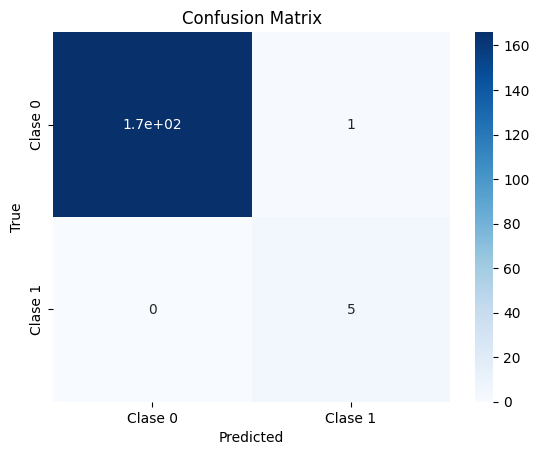

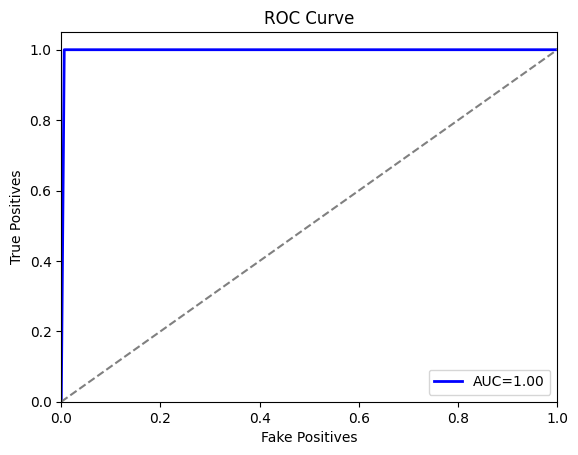

In [51]:
def evaluate_metrics(model,test_loader):
    model.eval()
    all_labels=[]
    all_preds=[]
    with torch.no_grad():
        for inputs,labels in test_loader:
            outputs=model(inputs)
            _, predicted=torch.max(outputs,1)
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
    all_labels=np.array(all_labels)
    all_preds=np.array(all_preds)
     # Calculando métricas
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix=confusion_matrix(all_labels,all_preds)

    #Create a ROC Curve
    fpr,tpr,_=roc_curve(all_labels,all_preds)
    roc_auc=auc(fpr,tpr)
    
    #Show metrics
    print(f'Accuracy:{precision:.2f}')
    print(f'Recall:{recall:.2f}')
    print(f'F1:{f1:.2f}')
    print('Confusion Matrix')
    print(conf_matrix)
    
    #Visualize Confusion Matrix
    conf_matrix_data=pd.DataFrame(conf_matrix,index=['Clase 0','Clase 1'],columns=['Clase 0','Clase 1'])
    sb.heatmap(conf_matrix_data,annot=True,cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    #Visualize ROC Curve
    plt.figure()
    plt.plot(fpr,tpr,color='blue',lw=2,label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1],[0,1],color='gray',linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('Fake Positives')
    plt.ylabel('True Positives')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

evaluate_metrics(model,test_loader)


In [52]:
torch.save(model.state_dict(), "CCP_Model.pth")